# Create tidy dataframe that keeps a subset of drugs that appear in the PDM experiments

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import sys
from time import time
import numpy as np
import pandas as pd

import sklearn
from collections import OrderedDict
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

SEED = 42

In [2]:
# utils_path = Path(os.getcwd()) / '../../utils'
# sys.path.append(str(utils_path))
# import utils

# Load data

In [3]:
datadir = Path('../../data/yitan/Data')
ccl_folds_dir = Path('../../data/yitan/CCL_10Fold_Partition')
pdm_folds_dir = Path('../../data/yitan/PDM_10Fold_Partition')
fea_data_name = 'CCL_PDM_TransferLearningData_rmFactor_0.0_ddNorm_std.pkl'

In [4]:
# Un-pickle files
import _pickle as cp

pkl_file = open(datadir/fea_data_name, 'rb')
res = cp.load(pkl_file)
ccl = cp.load(pkl_file)
drg = cp.load(pkl_file)
pkl_file.close()

print('res: {}'.format(res.shape))
print('ccl: {}'.format(ccl.shape))
print('drg: {}'.format(drg.shape))

res: (708662, 5)
ccl: (1430, 4582)
drg: (1402, 4392)


In [5]:
res = res.rename(columns={'index': 'idx', 'ccl_name': 'cclname', 'SOURCE': 'src', 'area_under_curve': 'auc'})

In [6]:
res.head()

,src,cclname,ctrpDrugID,auc,groupID
0,CCLE,CCL_61,Drug_11,0.7153,0.0000
1,CCLE,CCL_61,Drug_1,0.9579,0.9164
2,CCLE,CCL_61,Drug_2,0.4130,0.0082
3,CCLE,CCL_61,Drug_3,0.8004,0.0000
4,CCLE,CCL_61,Drug_4,0.5071,0.0607


# First look at the data

In [7]:
display(res[:2])
display(ccl.iloc[:2, :7])
display(drg.iloc[:2, :7])

,src,cclname,ctrpDrugID,auc,groupID
0,CCLE,CCL_61,Drug_11,0.7153,0.0000
1,CCLE,CCL_61,Drug_1,0.9579,0.9164


,geneGE_AARS,geneGE_ABCB6,geneGE_ABCC5,geneGE_ABCF1,geneGE_ABCF3,geneGE_ABHD4,geneGE_ABHD6
CCL_1,-0.125161,-0.400237,-0.960208,0.575207,-0.468406,-0.136257,0.083319
CCL_10,-0.217106,0.354776,-1.164841,0.328071,-0.735267,0.232990,-0.174979


,DD_MW|num,DD_AMW|num,DD_Sv|num,DD_Se|num,DD_Sp|num,DD_Si|num,DD_Mv|num
Drug_1,0.123446,0.526234,-0.072180,-0.088861,-0.058460,-0.083100,-0.009539
Drug_10,0.053188,1.966100,-0.333843,-0.379081,-0.359584,-0.398841,1.172374


In [8]:
res.groupby('src').agg({'cclname': 'nunique', 'ctrpDrugID': 'nunique'}).reset_index()

,src,cclname,ctrpDrugID
0,CCLE,474,24
1,CTRP,812,494
2,GDSC,670,238
3,NCI60,59,987
4,PDM,473,18
5,gCSI,357,16


# Get subset of features

In [9]:
def cnt_fea(df, fea_sep='_', verbose=True):
    """ Count the number of features per feature type. """
    dct = {}
    unq_prfx = df.columns.map(lambda x: x.split(fea_sep)[0]).unique() # unique feature prefixes
    for prfx in unq_prfx:
        fea_type_cols = [c for c in df.columns if (c.split(fea_sep)[0]) in prfx] # all fea names of specific type
        dct[prfx] = len(fea_type_cols)
    if verbose: print(dct)
    return dct

def extract_subset_fea(df, fea_list, fea_sep='_'):
    """ Extract features based feature prefix name. """
    fea = [c for c in df.columns if (c.split(fea_sep)[0]) in fea_list]
    df = df[fea]
    return df

In [10]:
ccl_fea_list = ['geneGE']
drg_fea_list = ['DD']

In [11]:
cnt_fea(ccl);
ccl = extract_subset_fea(ccl, fea_list=ccl_fea_list)
cnt_fea(ccl);

{'geneGE': 1927, 'c2cpMaxGE': 1328, 'c2cpMinGE': 1327}
{'geneGE': 1927}


In [12]:
cnt_fea(drg);
drg = extract_subset_fea(drg, fea_list=drg_fea_list)
cnt_fea(drg);

{'DD': 2344, 'ECFP': 1024, 'PFP': 1024}
{'DD': 2344}


# Subset drugs df for only PDM drugs

In [13]:
def get_drg_subset(res, drg_subset):
    if drg_subset == 'all':
        pass
    else:
        pdm_drg_names = res.loc[res['src']=='PDM', 'ctrpDrugID'].unique()
        if drg_subset == 'pdm':
            res = res[res['ctrpDrugID'].isin(pdm_drg_names)]
        elif drg_subset == 'common':
            drg_ccl_names = res.loc[res['src']!='PDM', 'ctrpDrugID'].unique()
            common_drgs_names = set(drg_ccl_names).intersection(set(pdm_drg_names))
            res = res[res['ctrpDrugID'].isin(common_drgs_names)]
    return res

In [14]:
df = get_drg_subset(res, drg_subset='common')
print(df['ctrpDrugID'].nunique())

16


In [15]:
print(res.shape)
res_pdm = res[res['src']=='PDM'].reset_index(drop=True)
print(res_pdm.shape)

print('Unique PDM drugs:', res_pdm['ctrpDrugID'].nunique())

(708662, 5)
(3330, 5)
Unique PDM drugs: 18


In [16]:
res_pdm.groupby(['ctrpDrugID']).agg({'src': 'nunique', 'cclname': 'nunique', 'groupID': 'nunique'}).reset_index()

,ctrpDrugID,src,cclname,groupID
0,Drug_117,1,361,74
1,Drug_1244,1,30,5
2,Drug_1245,1,29,5
3,Drug_146,1,8,2
4,Drug_16,1,199,37
5,Drug_180,1,221,41
6,Drug_188,1,337,65
7,Drug_244,1,45,9
8,Drug_329,1,176,32
9,Drug_347,1,35,6


Unique PDM samples: 599


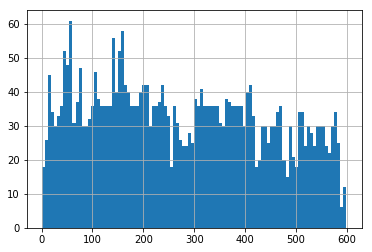

In [17]:
print('Unique PDM samples:', res_pdm.groupID.nunique());
res_pdm.groupID.hist(bins=100);

In [18]:
print(res.shape)
res_ccl = res[res['src']!='PDM'].reset_index(drop=True)
print(res_ccl.shape)

print('Unique cc; drugs:', res_ccl['ctrpDrugID'].nunique())

(708662, 5)
(705332, 5)
Unique cc; drugs: 1400


In [19]:
# Drug names used in both PDM and cell line studies
common_drgs_names = set(res_ccl['ctrpDrugID']).intersection(set(res_pdm['ctrpDrugID']))
len(common_drgs_names)

16

In [20]:
# Drugs used in PDM
drg_pdm = drg[drg.index.isin(res_pdm['ctrpDrugID'].unique())]
print('drg_pdm', drg_pdm.shape)

drg_pdm (18, 2344)


In [21]:
# Drug used in both PDM and cell line studies
drg_common = drg[drg.index.isin(set(common_drgs_names))]
print('drg_common', drg_common.shape)

drg_common (16, 2344)


In [24]:
in_dim_drg_embd = len(drg_pdm)
# in_dim_drg_embd = len(drg_common)
# in_dim_drg_embd = len(drg)

out_dim_drg_embd = (in_dim_drg_embd+1)//2

In [31]:
drg_pdm_enc = drg_pdm.copy()
enc = LabelEncoder()
drg_encoding = enc.fit_transform(drg_pdm_enc.index)
drg_pdm_enc.insert(loc=0, column='enc', value=drg_encoding, allow_duplicates=False)
tmp = drg_pdm_enc[['enc']]

In [40]:
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Input

In [45]:
in_drg_embd = Input(shape=(1,), name='in_drg_embd')

In [46]:
out_drg_embd = Embedding(input_dim = in_dim_drg_embd,
                output_dim = out_dim_drg_embd,
                input_length=1, name='out_drg_embd')(in_drg_embd)

In [47]:
drg = Model(inputs=in_drg_embd, outputs=out_drg_embd)

In [48]:
drg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_drg_embd (InputLayer)     (None, 1)                 0         
_________________________________________________________________
out_drg_embd (Embedding)     (None, 1, 9)              162       
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=1))
model.add(Flatten())

In [30]:
input_array = np.random.randint(len(drg_pdm_enc['enc']), size=(32, 1))
print(input_array)

In [32]:
model.compile('rmsprop', 'mse')
enc_embd = model.predict(input_array)
assert enc_embd.shape == (32, input_length, output_dim)

# Extract only numerical featues (drop categorical) in drugs df

In [16]:
print(drg.columns.map(lambda x: x.split('|')[-1]).unique())

idx = drg.columns.map(lambda x: True if x.split('|')[-1]=='num' else False)

print(drg.shape)
drg = drg[drg.columns[idx]]
print(drg.shape)

Index(['num', 'int'], dtype='object')
(18, 2344)
(18, 2301)


# Merge the entire df

In [17]:
ccl = ccl.reset_index().rename(columns={'index': 'cclname'})
drg = drg.reset_index().rename(columns={'index': 'ctrpDrugID'})

In [18]:
def merge_dfs(res_df, ccl_df, drg_df):
    """ Merge the following dfs: response, ccl fea, drug fea """
    mrg_df = pd.merge(res_df, ccl_df, on='cclname', how='inner')
    mrg_df = pd.merge(mrg_df, drg_df, on='ctrpDrugID', how='inner')
    return mrg_df

print('\nMerge ...')
mrg_df = merge_dfs(res, ccl, drg)
print('mrg_df.shape: {}'.format(mrg_df.shape))


Merge ...
mrg_df.shape: (24528, 4233)


In [21]:
mrg_df[:2]

,src,cclname,ctrpDrugID,auc,groupID,geneGE_AARS,geneGE_ABCB6,geneGE_ABCC5,geneGE_ABCF1,geneGE_ABCF3,...,DD_Psychotic-80|num,DD_Psychotic-50|num,DD_Hypertens-80|num,DD_Hypertens-50|num,DD_Hypnotic-80|num,DD_Hypnotic-50|num,DD_Neoplastic-80|num,DD_Neoplastic-50|num,DD_Infective-80|num,DD_Infective-50|num
0,CCLE,CCL_61,Drug_4,0.5071,0.0607,0.796453,1.185398,-0.279271,-1.612266,0.331601,...,-0.568319,-0.191697,-0.947474,-0.431286,-0.464975,-0.138457,-1.035826,-0.460377,-1.029885,-0.399006
1,CCLE,CCL_66,Drug_4,0.4997,0.0526,-2.655765,-0.594541,-1.202125,-0.158002,-0.651284,...,-0.568319,-0.191697,-0.947474,-0.431286,-0.464975,-0.138457,-1.035826,-0.460377,-1.029885,-0.399006


In [20]:
mrg_df['src'].value_counts()

CTRP     8952
NCI60    5573
GDSC     4014
PDM      3330
gCSI     1413
CCLE     1246
Name: src, dtype: int64

# PCA

In [12]:
def plt_explained_variance_pca(pca):
    # Plot explained variance PCA
    plt.figure(figsize=(8, 6))
    plt.plot(pca.explained_variance_ratio_, '--o')
    plt.xlabel('Principal component', fontsize=14)
    plt.ylabel('Variance explained (ratio)', fontsize=14)
    plt.grid(True)
    
def pca_exp_var(pca, k):
    print(np.sum(pca.explained_variance_ratio_[:k]))
    
def dump_pca_data(datadir, pca_x, k, fea_name):
    df = pd.DataFrame(pca_x.iloc[:, :k])
    df.to_csv(datadir/f'{fea_name}_pca{k}.csv', index=False)    

### GE (gene expression)

In [13]:
index = ge.index
fea_name = 'ge'

In [14]:
n = 1400
ge_pca = PCA(n_components=n, random_state=SEED, svd_solver='auto')
ge_pca_x = ge_pca.fit_transform(ge)
ge_pca_x = pd.DataFrame(ge_pca_x, index=index, columns=[f'{fea_name}_PC'+str(i+1) for i in range(n)])

In [15]:
pca_exp_var(ge_pca, k=1400)

0.9999387036197616


In [16]:
k=120
pca_exp_var(ge_pca, k)
dump_pca_data(datadir, ge_pca_x, k, fea_name=fea_name);

0.7543514715445558


In [17]:
k=550
pca_exp_var(ge_pca, k)
dump_pca_data(datadir, ge_pca_x, k, fea_name=fea_name);

0.9505486040316659


In [18]:
k=940
pca_exp_var(ge_pca, k=940)
dump_pca_data(datadir, ge_pca_x, k, fea_name=fea_name);

0.9909181163806056


### DD (drug descriptors)

In [19]:
index = dd.index
fea_name = 'dd'

In [20]:
n = 1400
dd_pca = PCA(n_components=n, random_state=SEED, svd_solver='auto')
dd_pca_x = dd_pca.fit_transform(dd)
dd_pca_x = pd.DataFrame(dd_pca_x, index=index, columns=[f'{fea_name}_PC'+str(i+1) for i in range(n)])

In [21]:
pca_exp_var(dd_pca, k=1400)

1.0


In [22]:
k=120
pca_exp_var(dd_pca, k)
dump_pca_data(datadir, dd_pca_x, k, fea_name=fea_name);

0.8572525902667022


In [23]:
k=500
pca_exp_var(dd_pca, k)
dump_pca_data(datadir, dd_pca_x, k, fea_name=fea_name);

0.9912240461620668
